### Windy Gridworld
1. 문제: 7x10(가로x세로) grid 내에서 특정 구간은 바람이 불어서 위로 이동하게 되어 있다. 이 때, 최종 도착지점까지 도달하는 문제를 sarsa로 학습시켜 optimal action-value function을 구해보자.
2. 조건: 
    - state: grid 내 위치 
    - action: 상, 하, 좌, 우로 이동
    - reward: 이동 시 -1, 도착 지점 도달 시 +1 
    - terminal: (3, 7) 혹은 37
    - start: (3, 0) 혹은 30 
    - policy: random policy로 시작하고 sarsa로 학습하면서 optimal policy로 수렴한다.
3. 학습 목표
    - Sarsa (on-policy TD control) 

In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
START = 30
END = 37
WORLD_WIDTH = 10
WORLD_HEIGHT = 7
UP, DOWN, LEFT, RIGHT = 0, 1, 2, 3

class WindyGridworld:
    def __init__(self):
        self.nA = 4
        self.nS = WORLD_HEIGHT * WORLD_WIDTH
        grid = np.zeros([WORLD_HEIGHT, WORLD_WIDTH])
        it = np.nditer(grid, flags=['multi_index'])
        P = defaultdict(lambda: [[] for i in range(self.nA)])              
        while not it.finished:
            s = it.iterindex
            y, x = it.multi_index            
            # 형태는 [prob, next_state, reward, done]            
            is_done = lambda s: s == END          
            if is_done(s):
                P[s][UP] = [1.0, s, 1, True]
                P[s][DOWN] = [1.0, s, 1, True]
                P[s][LEFT] = [1.0, s, 1, True]
                P[s][RIGHT] = [1.0, s, 1, True]
            else:
                wind = 0
                if 3 <= x <= 5 or x == 8:
                    wind = WORLD_WIDTH
                elif 6 <= x <= 7:
                    wind = 2 * WORLD_WIDTH                
                s_up = max(x, s - WORLD_WIDTH - wind)
                if WORLD_WIDTH - wind < 0:
                    s_down = max(x, s + WORLD_WIDTH - wind)
                else:
                    s_down = s + WORLD_WIDTH - wind if y != 6 else s 
                s_left = max(x - 1, s - 1 - wind) if x != 0 else max(0, s - wind)
                s_right = max(x + 1, s + 1 - wind) if x != 9 else max(0, s - wind)             
                P[s][UP] = [1.0, s_up, -1, False]
                P[s][DOWN] = [1.0, s_down, -1, False]
                P[s][LEFT] = [1.0, s_left, -1, False]
                P[s][RIGHT] = [1.0, s_right, -1, False]
            it.iternext()
        self.P = P
                
    def step(self, action):
        # boundary condition
        prob, next_state, reward, done = self.P[self.state][action]
        self.state = next_state
        return [prob, next_state, reward, done]
        
    def reset(self):
        self.state = START
        return self.state

### Epsilon greedy policy 
Exploration을 위해서 일정한 낮은 확률로 최적이 아닌 action을 선택하도록 한다.

$\pi(a \lvert s) \leftarrow \left\{
            \begin{array}{ll}
              1 - \epsilon + \epsilon/ \lvert \mathcal{A}(s) \rvert \text{ if } a = A^{\ast}\\
              \epsilon/ \lvert \mathcal{A}(s) \rvert \text{ if } a \neq A^{\ast}
            \end{array}
        \right.$

In [3]:
def epsilon_greedy_policy(Q, epsilon, nA):
    def policy_fn(observation):
        policy = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        policy[best_action] += 1.0 - epsilon
        return policy
    return policy_fn


### Sarsa

현재 action, state을 기준으로 다음 step으로 넘어갈 때의 reward, next_state, next_action을 토대로 action-value function을 update하는 방법을 **Sarsa** 라고 한다.

$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \big [ R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t) \big ]$

In [4]:
def sarsa(env, num_episodes, policy_fn, discount_factor=1.0, alpha=0.1, epsilon=0.1):
    Q = np.zeros([env.nS, env.nA])
    policy = policy_fn(Q, epsilon, env.nA)    
    counter = [0]
    i = 0
    for i_episode in range(num_episodes):
        state = env.reset()
        while True:
            i += 1
            action = np.random.choice(env.nA, p=policy(state))
            prob, next_state, reward, done = env.step(action)
            next_action = np.random.choice(env.nA, p=policy(next_state))
            Q[state][action] += alpha * (reward + discount_factor * Q[next_state][next_action] - Q[state][action])
            state = next_state
            action = next_action 
            if done:
                counter.append(i)
                break    
    return Q, counter

In [5]:
env = WindyGridworld()
Q, counter = sarsa(env, 170, epsilon_greedy_policy)

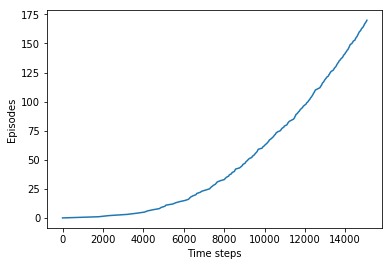

In [6]:
plt.plot(counter, range(0, len(counter)))
plt.xlabel('Time steps')
plt.ylabel('Episodes')
plt.show()
